In [1]:
cd /content/drive/MyDrive/5gz/path-finding-rl

/content/drive/MyDrive/5gz/path-finding-rl


In [2]:
!pip install -r requirements.txt

### 정량적 평가 지표

1. 총 Step / 총 Episode(=1226): 에피소드당 평균 이동한 칸의 수
2. Average Reward: 에피소드당 평균 매 item을 정확히 찾고 얻은 보상의 합(10기준 최대 80)
3. Fnish Rate: 전체 에피소드 수에 대해 아이템을 정확히 모두 찾고 시작 지점에 돌아온 비율(#finish/1226)

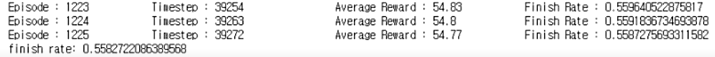

In [7]:
from string import ascii_uppercase
#from draw_utils import *
#from pyglet.gl import *
import numpy as np
import pandas as pd
import os
import torch
from pprint import pprint


# reward
move_reward = 0.1
obs_reward = 0.1
goal_reward = 10
print('reward:' , move_reward, obs_reward, goal_reward)

local_path = '/content/drive/MyDrive/5gz/path-finding-rl'

class Simulator:
    def __init__(self):
        '''
        height : 그리드 높이
        width : 그리드 너비 
        inds : A ~ Q alphabet list
        '''
        # Load train data
        self.files = pd.read_csv(os.path.join(local_path, "./data/factory_order_train.csv"))
# 테스트 파일 변수
        self.test_files = pd.read_csv(os.path.join(local_path, "./data/factory_order_test.csv"))
        self.height = 10
        self.width = 9
        self.inds = list(ascii_uppercase)[:17]

    def set_box(self):
        '''
        아이템들이 있을 위치를 미리 정해놓고 그 위치 좌표들에 아이템이 들어올 수 있으므로 그리드에 2으로 표시한다.
        데이터 파일에서 이번 에피소드 아이템 정보를 받아 가져와야 할 아이템이 있는 좌표만 3으로 표시한다.
        self.local_target에 에이전트가 이번에 방문해야할 좌표들을 저장한다.
        따라서 가져와야하는 아이템 좌표와 end point 좌표(처음 시작했던 좌표로 돌아와야하므로)가 들어가게 된다.

        수정)
        원핫인코딩을 위해 각 그리드를 0~4로 표시
        모든 타겟을 한번에 표시하지 않고 첫 타겟만 표시
        '''
        box_data = pd.read_csv(os.path.join(local_path, "./data/box.csv"))

        # 물건이 들어있을 수 있는 경우
        for box in box_data.itertuples(index = True, name ='Pandas'):
            self.grid[getattr(box, "row")][getattr(box, "col")] = 2

        # 물건이 실제 들어있는 경우
        order_item = list(set(self.inds) & set(self.items))
        order_csv = box_data[box_data['item'].isin(order_item)]

# 로컬타겟 리스트만 확보
# 그리드에는 지금 가야하는 아이템만 목표로 설정
        for order_box in order_csv.itertuples(index = True, name ='Pandas'):
            #self.grid[getattr(order_box, "row")][getattr(order_box, "col")] = 3
            # local target에 가야 할 위치 좌표 넣기
            self.local_target.append(
                [getattr(order_box, "row"),
                 getattr(order_box, "col")]
                )

        self.local_target.sort()
        self.local_target.append([9,4]) 

        # 알파벳을 Grid에 넣어서 -> grid에 2Dconv 적용 가능

    def set_obstacle(self):
        '''
        장애물이 있어야하는 위치는 미리 obstacles.csv에 정의되어 있다. 이 좌표들을 0으로 표시한다.
        '''
        obstacles_data = pd.read_csv(os.path.join(local_path, "./data/obstacles.csv"))
        for obstacle in obstacles_data.itertuples(index = True, name ='Pandas'):
            self.grid[getattr(obstacle, "row")][getattr(obstacle, "col")] = 0


    def reset(self, epi, test = False):
        '''
        reset()은 첫 스텝에서 사용되며 그리드에서 에이전트 위치가 start point에 있게 한다.
        :param epi: episode, 에피소드 마다 가져와야 할 아이템 리스트를 불러올 때 사용
        :return: 초기셋팅 된 그리드
        :rtype: numpy.ndarray
        _____________________________________________________________________________________
        items : 이번 에피소드에서 가져와야하는 아이템들
        terminal_location : 현재 에이전트가 찾아가야하는 목적지
        local_target : 한 에피소드에서 찾아가야하는 아이템 좌표, 마지막 엔드 포인트 등의 위치좌표들
        actions: visualization을 위해 에이전트 action을 저장하는 리스트
        curloc : 현재 위치
        '''

        # initial episode parameter setting
        self.epi = epi
        if test:
            self.items = list(self.test_files.iloc[self.epi])[0]
        else:
            self.items = list(self.files.iloc[self.epi])[0]
        self.cumulative_reward = 0
        self.terminal_location = None
        self.local_target = []
        self.actions = []

        # initial grid setting
        self.grid = np.ones((self.height, self.width), dtype="float16")

        # set information about the gridworld
        self.set_box()
        self.set_obstacle()

        # start point를 grid에 표시
        self.curloc = [9, 4]
        self.grid[int(self.curloc[0])][int(self.curloc[1])] = 4
        
        self.done = False
        
# 그리드(10,0)가 아니라 원핫인코딩(5,10,9)된 상태 반환
        return self.get_state()

    def apply_action(self, action, cur_x, cur_y):
        '''
        에이전트가 행한 action대로 현 에이전트의 위치좌표를 바꾼다.
        action은 discrete하며 4가지 up,down,left,right으로 정의된다.
        
        :param x: 에이전트의 현재 x 좌표
        :param y: 에이전트의 현재 y 좌표
        :return: action에 따라 변한 에이전트의 x 좌표, y 좌표
        :rtype: int, int
        '''
        new_x = cur_x
        new_y = cur_y
        # up
        if action == 0:
            new_x = cur_x - 1
        # down
        elif action == 1:
            new_x = cur_x + 1
        # left
        elif action == 2:
            new_y = cur_y - 1
        # right
        else:
            new_y = cur_y + 1

        return int(new_x), int(new_y)


    def get_reward(self, new_x, new_y, out_of_boundary):
        '''
        get_reward함수는 리워드를 계산하는 함수이며, 상황에 따라 에이전트가 action을 옳게 했는지 판단하는 지표가 된다.
        :param new_x: action에 따른 에이전트 새로운 위치좌표 x
        :param new_y: action에 따른 에이전트 새로운 위치좌표 y
        :param out_of_boundary: 에이전트 위치가 그리드 밖이 되지 않도록 제한
        :return: action에 따른 리워드
        :rtype: float
        '''

        # 바깥으로 나가는 경우
        if any(out_of_boundary):
            reward = obs_reward
                       
        else:
            # 장애물에 부딪히는 경우 
            if self.grid[new_x][new_y] == 0:
                reward = obs_reward  

            # 현재 목표에 도달한 경우
            elif new_x == self.terminal_location[0] and new_y == self.terminal_location[1]:
                reward = goal_reward

            # 그냥 움직이는 경우 
            else:
                reward = move_reward

        return reward

    def step(self, action):
        ''' 
        에이전트의 action에 따라 step을 진행한다.
        action에 따라 에이전트 위치를 변환하고, action에 대해 리워드를 받고, 어느 상황에 에피소드가 종료되어야 하는지 등을 판단한다.
        에이전트가 endpoint에 도착하면 gif로 에피소드에서 에이전트의 행동이 저장된다.
        :param action: 에이전트 행동
        :return: # 리턴 수정
            s, 원핫 인코딩 된 그리드
            action, 에이전트 행동
            reward, 리워드
            cumulative_reward, 누적 리워드
            s_prime, 다음 상태
            done, 종료 여부
            goal_ob_reward, goal까지 아이템을 모두 가지고 돌아오는 finish율 계산을 위한 파라미터
        :rtype: tensor(float32), int, float, float, tensor(float32), bool, bool/str
        (Hint : 시작 위치 (9,4)에서 up말고 다른 action은 전부 장애물이므로 action을 고정하는 것이 좋음)
        '''

        self.terminal_location = self.local_target[0]
# 현재 목표를 3으로 표시
        self.grid[int(self.terminal_location[0])][int(self.terminal_location[1])] = 3
        s = self.get_state()
        #print('start:', self.curloc, 'item:', self.terminal_location)
        #pprint(self.grid)
        cur_x,cur_y = self.curloc
        self.actions.append((cur_x, cur_y))
        print('now:', self.curloc, 'action:', action)

        goal_ob_reward = False
        
        new_x, new_y = self.apply_action(action, cur_x, cur_y)

        out_of_boundary = [new_x < 0, new_x >= self.height, new_y < 0, new_y >= self.width]

        # 바깥으로 나가는 경우 종료
        if any(out_of_boundary):
            self.done = True
            goal_ob_reward = True
        else:
            # 장애물에 부딪히는 경우 종료
            if self.grid[new_x][new_y] == 0:
                #print('아이쿠!')
                self.done = True
                goal_ob_reward = True

            # 현재 목표에 도달한 경우, 다음 목표설정
            elif new_x == self.terminal_location[0] and new_y == self.terminal_location[1]:

                # end point 일 때
                if [new_x, new_y] == [9,4]:
                    self.done = True
                else:
                    self.done = False

                self.local_target.remove(self.local_target[0])
                self.grid[cur_x][cur_y] = 1
                self.grid[new_x][new_y] = 4
                goal_ob_reward = True
                self.curloc = [new_x, new_y]
                
            else:
                # 그냥 움직이는 경우 
                self.grid[cur_x][cur_y] = 1
                self.grid[new_x][new_y] = 4
                self.curloc = [new_x,new_y]
                self.done = False

        print(self.grid)
        print('done:', self.done)
        print()
                
        reward = self.get_reward(new_x, new_y, out_of_boundary)
        self.cumulative_reward += reward
        s_prime = self.get_state()

        return s, action, reward, self.cumulative_reward, s_prime, self.done, goal_ob_reward

    def get_state(self): # 현재의 grid를  원핫인코딩해주는 함수
        oh_state = np.eye(5)[self.grid.astype('int')]
        oh_state = torch.from_numpy(oh_state)
        oh_state = torch.permute(oh_state, (2,0,1))
        oh_state = torch.unsqueeze(oh_state,0) # tensor.size(1,5,10,9)
        oh_state = oh_state.type(torch.float32)
        return oh_state

if __name__ == "__main__":

    sim = Simulator()
    files = pd.read_csv("./data/factory_order_train.csv")

    for epi in range(1): # len(files)):
        items = list(files.iloc[epi])[0]
        done = False
        i = 0
        obs = sim.reset(epi)
        #actions = [0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1]
        #actions = [0,0,2,0,0,0,0,0,0,0,0,3,3,3,3,3,1,2,2,2,1,1,1,1,1,1,1,2,1]
        actions = [0,0,0]

        while done == False:

            i += 1
            next_obs, action, reward, cumul, s_prime, done, goal_reward = sim.step(actions[i])

            obs = next_obs

            if (done == True) or (i == (len(actions)-1)):
                i =0


reward: 0.1 0.1 10
now: [9, 4] action: 0
[[2. 2. 2. 3. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 1. 1. 1. 1. 1. 1. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [1. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 4. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]]
done: False

now: [8, 4] action: 0
[[2. 2. 2. 3. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 1. 1. 1. 1. 1. 1. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [1. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 4. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]]
done: False

now: [7, 4] action: 0
[[2. 2. 2. 3. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 1. 1. 1. 1. 1. 1. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [1. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 4. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 

```python

if __name__ == "__main__":

    sim = Simulator()
    files = pd.read_csv("./data/factory_order_train.csv")

    for epi in range(1): # len(files)):
        items = list(files.iloc[epi])[0]
        done = False
        i = 0
        obs = sim.reset(epi)
        #actions = [0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1]
        actions = [0,0,2,0,0,0,0,0,0,0,0,3,3,3,3,3,1,2,2,2,1,1,1,1,1,1,1,2,1]

        while done == False:
            
            i += 1
            next_obs, reward, cumul ,done, goal_reward = sim.step(actions[i])

            obs = next_obs

            if (done == True) or (i == (len(actions)-1)):
                i =0
```

In [8]:
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 32

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, cr_lst, s_prime_lst, done_mask_lst, gr_lst = [], [], [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, cr, s_prime, done_mask, gr = transition
            s = torch.squeeze(s)
            s_prime = torch.squeeze(s)
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            cr_lst.append([cr])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])
            gr_lst.append([gr])

        return torch.stack(s_lst, dim=0), torch.tensor(a_lst), torch.tensor(r_lst), torch.tensor(cr_lst), \
               torch.stack(s_prime_lst, dim=0), torch.tensor(done_mask_lst), torch.tensor(gr_lst)
    
    def size(self):
        return len(self.buffer)

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()

        self.conv1 = nn.Conv2d(5, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(1920, 128)
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x):
        #print('origin', x.shape)
        x = F.relu(self.conv1(x))
        #print('conv1', x.shape)
        x = F.relu(self.conv2(x))
        #print('conv1', x.shape)
        x = torch.flatten(x, 1)
        #print('flatten', x.shape)
        x = F.relu(self.fc1(x))
        #print('dence1', x.shape)
        x = self.fc2(x)
        #print('dence2', x.shape)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,3)
        else : 
            return out.argmax().item()
            
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s, a, r, cr, s_prime, done_mask, gr = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


``` python

def main():
    env = gym.make('CartPole-v1')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for n_epi in range(10000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)      
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            score += r
            if done:
                break
            
        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                            n_epi, score/print_interval, memory.size(), epsilon*100))
            score = 0.0
    env.close()

if __name__ == '__main__':
    main()
```

In [9]:
def main():
    sim = Simulator()
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)

    for epi in range(len(sim.files)):
        s = sim.reset(epi)
        epsilon = max(0.01, 0.999 - 0.01*(epi/200))
        done = False
        print('episode {}, epsilon {}, memory{}'.format(epi,epsilon,len(memory)))

        while not done:
            for i in range(10):
                action = q.sample_action(s.float(), epsilon)
                s, a, r, cr, s_prime, done, gr = sim.step(action)
                #done = 0.0 if done else 1.0
                memory.put((s, a, r, cr, s_prime, done, gr))
                s = s_prime

                score += r
                if done:
                    print('끝', i)
                    print('========================================')
                    break

        if memory.size()>4000:
            train(q, q_target, memory, optimizer)
                   
                    
if __name__ == '__main__':
    main()

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[[3. 2. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 1. 1. 1. 1. 1. 1. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [1. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 4. 0. 0. 0. 0.]]
done: True

끝 0
episode 39689, epsilon 0.01
now: [9, 4] action: 1
[[2. 3. 2. 2. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 1. 1. 1. 1. 1. 1. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [1. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 4. 0. 0. 0. 0.]]
done: True

끝 0
episode 39690, epsilon 0.01
now: [9, 4] action: 3
[[2. 2. 2. 3. 2. 2. 2. 2. 2.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [2. 1. 1. 1. 1. 1. 1. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [2. 1. 0. 1. 0. 1. 0. 1. 2.]
 [1. 1. 0. 1. 0. 1. 0. 1. 1.]
 [1. 1. 1. 1. 1. 1. 